#1. Impor Perpustakaan yang Diperlukan

In [1]:
!pip install --upgrade google-cloud-bigquery
!pip install --upgrade google-auth

from google.colab import auth
auth.authenticate_user()


In [10]:
import pandas as pd
import numpy as np
from google.colab import auth
from google.cloud import bigquery
from datetime import datetime, timedelta
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Autentikasi ke Google Cloud
auth.authenticate_user()


#2. Menghubungkan ke BigQuery dan Mengambil Data

In [11]:
project_id = 'rakamin-kf-analytics-01'
client = bigquery.Client(project=project_id)

# Query untuk mendapatkan data penjualan bulanan
query = """
SELECT
  DATE_TRUNC(date, MONTH) AS month,
  SUM(nett_sales) AS monthly_income
FROM
  `kimia_farma.kf_analisa_transaksi`
GROUP BY
  month
ORDER BY
  month;
"""

df = client.query(query).to_dataframe()
df['month'] = pd.to_datetime(df['month'])
df.set_index('month', inplace=True)


#3. Membuat Model SARIMA

In [12]:
# Pastikan data tidak ada nilai yang hilang
df = df.asfreq('MS')

# Menggunakan SARIMA untuk pemodelan
model = sm.tsa.SARIMAX(df['monthly_income'],
                       order=(1, 1, 1),   # ARIMA parameters (p,d,q)
                       seasonal_order=(1, 1, 1, 12),  # Seasonal parameters (P,D,Q,s)
                       enforce_stationarity=False,
                       enforce_invertibility=False)
results = model.fit()

# Summary dari model
print(results.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                     monthly_income   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -412.212
Date:                            Mon, 03 Jun 2024   AIC                            834.423
Time:                                    18:51:08   BIC                            839.646
Sample:                                01-01-2020   HQIC                           835.557
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3586      0.418     -0.858      0.391      -1.178       0.461
ma.L1         -0.3041      0.175   

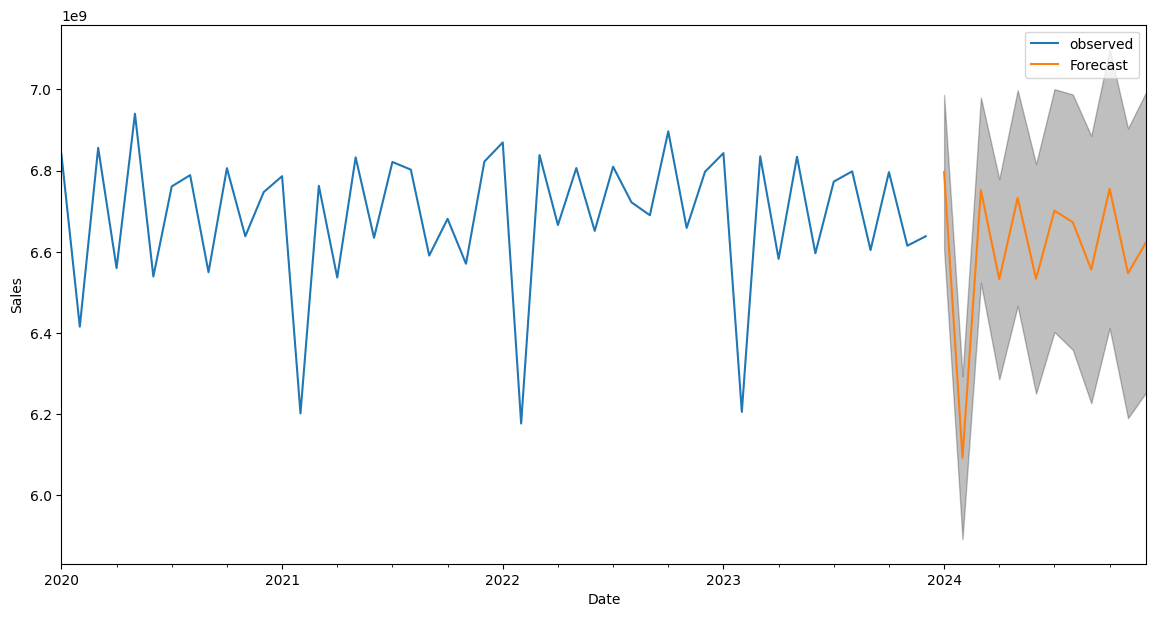

In [13]:
# Membuat prediksi untuk 12 bulan ke depan
pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()

# Menampilkan hasil prediksi
ax = df['monthly_income'].plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

# Menyimpan hasil prediksi ke dataframe
forecast_df = pred_uc.predicted_mean.reset_index()
forecast_df.columns = ['month', 'predicted_monthly_income']


In [15]:
print(forecast_df)

        month  predicted_monthly_income
0  2024-01-01              6.796025e+09
1  2024-02-01              6.091292e+09
2  2024-03-01              6.751476e+09
3  2024-04-01              6.531598e+09
4  2024-05-01              6.732122e+09
5  2024-06-01              6.532797e+09
6  2024-07-01              6.701027e+09
7  2024-08-01              6.672445e+09
8  2024-09-01              6.555714e+09
9  2024-10-01              6.755334e+09
10 2024-11-01              6.546489e+09
11 2024-12-01              6.624019e+09


#4. Mengunggah Hasil Prediksi ke BigQuery

In [14]:
# Mengunggah hasil prediksi ke tabel BigQuery
table_id = 'kimia_farma.sales_forecast_2024'
client.load_table_from_dataframe(forecast_df, table_id).result()
print(f"Hasil prediksi telah diunggah ke tabel {table_id}")


Hasil prediksi telah diunggah ke tabel kimia_farma.sales_forecast_2024
